Let's analyze some behavior

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import physutils as phys
import dbio
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
%matplotlib inline

plt.style.use('ggplot')

# Theory

We assume for the moment that the pop times are normall distributed $\tau \sim \mathcal{N}(\mu, \sigma^2)$, and that the reward for stopping at time $t$ is proportional to the elapsed time: $R = \alpha t$. Given these assumptions, the expected value of stopping at time $t$ is
$$
E[R|t] = \alpha t \cdot p(\tau > t) = \alpha t ( 1 - \mathrm{CDF}(t))
$$
where $\mathrm{CDF}(t)$ is the cumulative distribution function of $\tau$:
$$
\mathrm{CDF}(t) = \frac{1}{2}\left[ 1 + \mathrm{erf}\left(\frac{t - \mu}{\sqrt{2}\sigma}\right) \right]
$$
which means that the optimal stop time is given by
$$
\frac{d}{dt}E[R|t] = 0 = \alpha \left[ 1 - \mathrm{CDF}(t) - t\cdot \mathrm{PDF}(t)\right]
$$

We can also plot these reward curves for the experimental values of $\mu$ and $\sigma$:

mean: 10.0, std: 3.0, optimal: 7.74
mean: 6.5, std: 1.95, optimal: 5.03
mean: 3.0, std: 0.9, optimal: 2.32


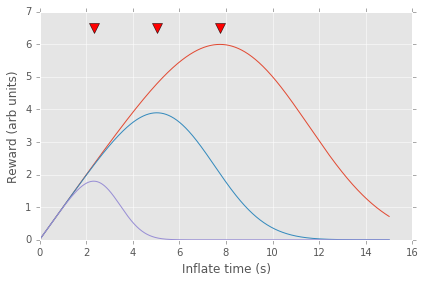

In [2]:
# these are the actual values from the task
mean_pop_times = np.array([10, 6.5, 3, 6.5])
std_pop_times = 0.3 * mean_pop_times

tt = np.linspace(0, 15, 5000)  # time axis
opt_times = []
for idx in range(3):
    # plot reward curve as a function of time
    mu, sig = mean_pop_times[idx], std_pop_times[idx]
    R = tt * stats.norm.sf(tt, loc=mu, scale=sig)
    plt.plot(tt, R)
    
    # calculate optimal reward time
    this_opt = tt[np.argmax(R)]  
    opt_times.append(this_opt)
    
    # mark optimal reward times
    plt.plot(this_opt, 6.5, marker='v', markersize=10, linestyle='none', color='red')
    
    print("mean: {:2}, std: {:.3}, optimal: {:.3}".format(mu, sig, this_opt))

# for control trials (mean_pop_times[-1]), there is no choice,
# so make optimal the actual
opt_times.append(mean_pop_times[-1])
    
plt.ylabel("Reward (arb units)")
plt.xlabel("Inflate time (s)")
plt.ylim(0, 7);
plt.tight_layout()

plt.savefig("figures/optimal_behavior.svg")

# Load data

In [3]:
# open data file
dbname = os.path.expanduser('data/bart.hdf5')

# get list of all patient, dataset pairs corresponding to behavior
evtlist = pd.read_hdf(dbname, '/meta/evlist')

# remove subject 10, who did a previous version of the task
evtlist = evtlist.query('patient != 10')

# Try some basic analyses

Single subject:

In [4]:
dtup = 22, 1

evt = dbio.fetch(dbname, 'events', *dtup)

## Mean inflate time for stop trials

In [5]:
stops_only = evt.query("result == 'banked'")

In [6]:
inflate_time_means = stops_only.groupby('trial_type').inflate_time.mean()
inflate_time_stds = stops_only.groupby('trial_type').inflate_time.std()

## Plot density of times

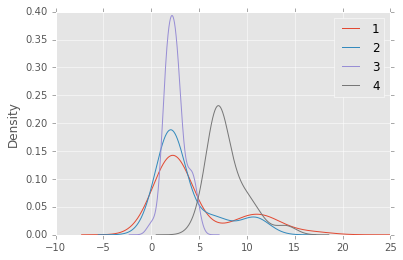

In [7]:
stops_only.groupby('trial_type').inflate_time.plot(kind='kde', legend=True);

## Get a maximum-likelihood estimate of the mean and standard deviation

We assume participants' *intended* stop times are drawn from a normal distribution, but we will not necessarily see the upper tail of this distribution due to balloon popping. The following functions allow us to calculate a maximum likelihood estimate of the paramters of this distribution based on observations from both "stop" and "pop" trials.

In [8]:
# define a function that takes stop and pop times as arguments and returns a function
# giving the log likelihood for a given mean and standard deviation
def make_LL_function(stops, pops):
    def LLfun(x):
        mean, std = x
        observed_LL = np.sum(stats.norm.logpdf(stops, loc=mean, scale=std))
        cens_LL = np.sum(stats.norm.logsf(pops, loc=mean, scale=std))
        return observed_LL + cens_LL
    return LLfun

In [9]:
# now iterate through dataset, calculating ML estimates for each trial type
def fit_subj_pars(evt):
    allpars = []
    for grpname, grpdf in evt.groupby('trial_type'):
        stops = grpdf.query("result == 'banked'").inflate_time.values
        pops = grpdf.query("result == 'popped'").inflate_time.values

        # get log likelihood function
        LLfun = make_LL_function(stops, pops)

        # minimize -log(likelihood)
        objfun = lambda x: -LLfun(x)

        # initial guess
        grpind = int(grpname) - 1
        x0 = [mean_pop_times[grpind], std_pop_times[grpind]]

        # minimize
        constraints = [{'type': 'ineq', 'fun': lambda x: x[0] > 0},
                       {'type': 'ineq', 'fun': lambda x: x[0] < 20}, 
                       {'type': 'ineq', 'fun': lambda x: x[1] > 0}]
        res = opt.minimize(objfun, x0, constraints=constraints)

        # package into series
        pars = pd.Series(res.x, index=['mean', 'std'], name=grpname)
        allpars.append(pars)

    return pd.concat(allpars, axis=1)

In [10]:
subjpars = fit_subj_pars(evt)

/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1858: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Behavior vs optimal (first pass)

We'll do this the naive way, using only stop trials...

In [11]:
allsubs = []
for _, dtup in evtlist.iterrows():
    dtup = tuple(dtup)
    evt = dbio.fetch(dbname, 'events', *dtup)
    
    stops_only = evt.query("result == 'banked'")
    inflate_time_means = stops_only.groupby('trial_type').inflate_time.mean()
    inflate_time_means.name = dtup
    
    allsubs.append(inflate_time_means)

naive_meandat = pd.concat(allsubs, axis=1).transpose()

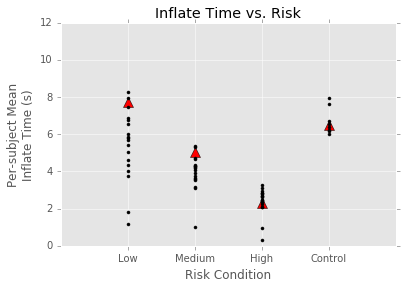

In [12]:
xpos = [1, 2, 3, 4]
plt.plot(xpos, opt_times, marker='^', linestyle='none', markersize=10,
         color='r');
plt.plot(xpos, naive_meandat.values.T, marker='.', linestyle='none', color='k');
plt.xlim([0, 5]);
plt.ylim([0, 12]);
plt.xticks(xpos, ['Low', 'Medium', 'High', 'Control']);
plt.xlabel('Risk Condition');
plt.ylabel('Per-subject Mean\nInflate Time (s)');
plt.title('Inflate Time vs. Risk');

The observed behavior seems well below optimal for the Low and Medium conditions, but our estimates are biased downward, since we only used stop trials. A better approach is to estimate participants' intended mean using both stop and (censored) pop trials.

# Behavior vs optimal (better)

This time, we'll incorporate pop trials, which are censored but still informative:

In [13]:
# now incorporate censored data
allsubs = []
for _, dtup in evtlist.iterrows():
    dtup = tuple(dtup)
    evt = dbio.fetch(dbname, 'events', *dtup)
    
    subjpars = fit_subj_pars(evt)
    
    allsubs.append(subjpars.loc['mean'])

meandat = pd.concat(allsubs, axis=1).transpose()

/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jmxp/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1858: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


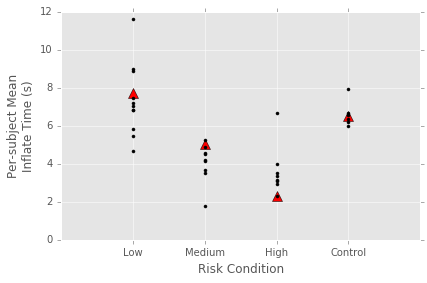

In [14]:
xpos = [1, 2, 3, 4]
plt.plot(xpos, opt_times, marker='^', linestyle='none', markersize=10,
         color='r');
plt.plot(xpos, meandat.values.T, marker='.', linestyle='none', color='k');
plt.xlim([0, 5]);
plt.ylim([0, 12]);
plt.xticks(xpos, ['Low', 'Medium', 'High', 'Control']);
plt.xlabel('Risk Condition');
plt.ylabel('Per-subject Mean\nInflate Time (s)');
plt.tight_layout()

plt.savefig("figures/actual_behavior_vs_optimal.svg")

Note that now, behavior in the Low and Medium conditions is closer to optimal, whereas it seems participants inflate balloons longer than optimal in the High Risk condition.

In [15]:
print("Difference due to censoring correction:")
meandat.mean() - naive_meandat.mean()

Difference due to censoring correction:


1    1.931941
2    0.102352
3    1.235610
4   -0.069985
dtype: float64

## Get fraction of pop trials for each subject

In [16]:
def calc_pop_frac(evt):
    return evt.query("result == 'popped'").shape[0] / evt.shape[0]

In [17]:
allsubs = []
for _, dtup in evtlist.iterrows():
    dtup = tuple(dtup)
    evt = dbio.fetch(dbname, 'events', *dtup)
    
    subjpars = evt.groupby('trial_type').apply(calc_pop_frac)
    
    allsubs.append(subjpars)

popfrac = pd.concat(allsubs, axis=1).transpose()
popfrac = popfrac.drop(4, axis=1)  # drop control condition

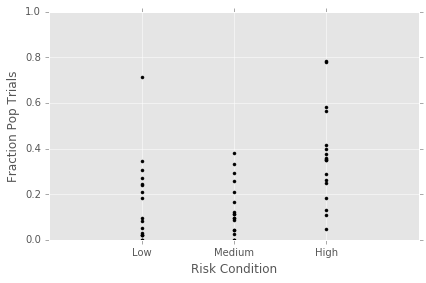

In [18]:
xpos = [1, 2, 3]
wid = 0.25
#plt.plot(xpos, popfrac.median(), marker='^', linestyle='none', markersize=10, color='r');
plt.plot(xpos, popfrac.values.T, marker='.', linestyle='none', color='k');
plt.xlim([0, 4]);
plt.ylim([0, 1]);
plt.xticks(xpos, ['Low', 'Medium', 'High', 'Control']);
plt.xlabel('Risk Condition');
plt.ylabel('Fraction Pop Trials');
plt.tight_layout()

plt.savefig("figures/fraction_pop_trials.svg")